In [1]:
import pandas as pd
import numpy as np
import numpy.random as nr
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
import pickle

In [2]:
def process(data):

    '''
    function to process dataframe by replacing missing, infinity values with -999

    args:: 
      data:  dataframe to be operated on
    
    returns dataframe with replaced values
    '''
    
    cols = list(data.columns)
    for _ in cols:

        data[_] = np.where(data[_] == np.inf, -999, data[_])
        data[_] = np.where(data[_] == np.nan, -999, data[_])
        data[_] = np.where(data[_] == -np.inf, -999, data[_])
        
    return data

In [3]:
def fill_missing_values(df):
    cols = list(df.columns)
    for _ in cols:

        df[_] = np.where(df[_] == np.inf, -999, df[_])
        df[_] = np.where(df[_] == np.nan, -999, df[_])
        df[_] = np.where(df[_] == -np.inf, -999, df[_])
        
    return df

In [4]:
PWD = '/media/Data-B/my_research/Geoscience_FL/data_well_log/'

A = np.load('penalty_matrix.npy')
train = pd.read_csv(PWD + 'train.csv', sep=';')
test = pd.read_csv(PWD + 'test_with_lables.csv')

The augment_features_window function is used to concatenate feature windows in a given dataset. It takes two inputs: X, which is the input feature matrix, and N_neig, representing the number of neighboring windows to consider on each side of the current window. The function performs the following steps:

In [5]:
#Paulo Bestagini's feature augmentation technique from SEG 2016 ML competition
#Link : https://github.com/seg/2016-ml-contest/tree/master/ispl


# Feature windows concatenation function
def augment_features_window(X, N_neig):
    
    # Parameters
    N_row = X.shape[0]
    N_feat = X.shape[1]
 
    # Zero padding
    X = np.vstack((np.zeros((N_neig, N_feat)), X, (np.zeros((N_neig, N_feat)))))
 
    # Loop over windows
    X_aug = np.zeros((N_row, N_feat*(2*N_neig+1)))
    for r in np.arange(N_row)+N_neig:
        this_row = []
        for c in np.arange(-N_neig,N_neig+1):
            this_row = np.hstack((this_row, X[r+c]))
        X_aug[r-N_neig] = this_row
 
    return X_aug
 
# Feature gradient computation function
def augment_features_gradient(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    return X_grad
 
# Feature augmentation function
def augment_features(X, well, depth, N_neig=1):
    
    # Augment features
    X_aug = np.zeros((X.shape[0], X.shape[1]*(N_neig*2+2)))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_win = augment_features_window(X[w_idx, :], N_neig)
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X_aug_win, X_aug_grad), axis=1)
    
    # Find padded rows
    padded_rows = np.unique(np.where(X_aug[:, 0:7] == np.zeros((1, 7)))[0])
    
    return X_aug, padded_rows

def score(y_true, y_pred):

    '''
    custom metric used for evaluation
    args:
      y_true: actual prediction
      y_pred: predictions made
    '''

    S = 0.0
    y_true = y_true.astype(int)
    y_pred = y_pred.astype(int)
    for i in range(0, y_true.shape[0]):
        S -= A[y_true[i], y_pred[i]]
    return S/y_true.shape[0]

In [6]:
def show_evaluation(pred, true):

  '''

  function to show model performance and evaluation
  args:
    pred: predicted value(a list)
    true: actual values (a list)

  prints the custom metric performance, accuracy and F1 score of predictions

  '''

  print(f'Default score: {score(true.values, pred)}')
  print(f'Accuracy is: {accuracy_score(true, pred)}')
  print(f'F1 is: {f1_score(pred, true.values, average="weighted")}')

In [7]:
lithology = train['FORCE_2020_LITHOFACIES_LITHOLOGY']

lithology_numbers = {30000: 0,
                        65030: 1,
                        65000: 2,
                        80000: 3,
                        74000: 4,
                        70000: 5,
                        70032: 6,
                        88000: 7,
                        86000: 8,
                        99000: 9,
                        90000: 10,
                        93000: 11}

labels = lithology.map(lithology_numbers)

In [8]:
def preprocess(df):
    df_well = df.WELL.values
    df_depth = df.DEPTH_MD.values

    print(f"Shape of concatenated dataframe before dropping columns: {df.shape}")

    cols_to_drop = ['SGR', 'DTS', 'RXO', 'ROPA', 'FORCE_2020_LITHOFACIES_LITHOLOGY', 'FORCE_2020_LITHOFACIES_CONFIDENCE']
    df = df.drop(columns=cols_to_drop, errors='ignore')

    print(f"Shape of dataframe after dropping columns: {df.shape}")
    
    # Label encoding the GROUP, FORMATION, and WELLS features
    df['GROUP_encoded'] = df['GROUP'].astype('category').cat.codes
    df['FORMATION_encoded'] = df['FORMATION'].astype('category').cat.codes
    df['WELL_encoded'] = df['WELL'].astype('category').cat.codes
    print(f"Shape of dataframe after label encoding columns: {df.shape}")

    # Further preparation to split dataframe into train and test datasets after preparation
    df = df.drop(['WELL', 'GROUP', 'FORMATION'], axis=1)

    df = df.fillna(-999)
    df = process(df)

    print(f"Dataframe columns: {df.columns}")
    print(f"Shape of the dataset BEFORE augmentation: {df.shape}")

    augmented_df, _ = augment_features(pd.DataFrame(df).values, df_well, df_depth)

    print(f"Shape of the dataset AFTER augmentation: {augmented_df.shape}")

    return augmented_df


In [9]:
trainset = preprocess(train)
testset = preprocess(test)

Shape of concatenated dataframe before dropping columns: (1170511, 29)
Shape of dataframe after dropping columns: (1170511, 23)
Shape of dataframe after label encoding columns: (1170511, 26)
Dataframe columns: Index(['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'RSHA', 'RMED', 'RDEP',
       'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS', 'ROP', 'DCAL', 'DRHO',
       'MUDWEIGHT', 'RMIC', 'GROUP_encoded', 'FORMATION_encoded',
       'WELL_encoded'],
      dtype='object')
Shape of the dataset BEFORE augmentation: (1170511, 23)
Shape of the dataset AFTER augmentation: (1170511, 92)
Shape of concatenated dataframe before dropping columns: (136786, 28)
Shape of dataframe after dropping columns: (136786, 23)
Shape of dataframe after label encoding columns: (136786, 26)
Dataframe columns: Index(['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'RSHA', 'RMED', 'RDEP',
       'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS', 'ROP', 'DCAL', 'DRHO',
       'MUDWEIGHT', 'RMIC', 'GROUP_encoded', 'FO

In [10]:
split = 10
kf = StratifiedKFold(n_splits=split, shuffle=True)

open_test = np.zeros((len(testset), 12))
      
#100 n-estimators and 10 max-depth
model = XGBClassifier(n_estimators=100, max_depth=10, booster='gbtree',
                            objective='multi:softprob', learning_rate=0.1, random_state=0,
                            subsample=0.9, colsample_bytree=0.9, tree_method='gpu_hist',
                            eval_metric='mlogloss', verbose=2020, reg_lambda=1500)
      
 
i = 1
for (train_index, test_index) in kf.split(pd.DataFrame(trainset), pd.DataFrame(labels)):
        X_train, X_test = pd.DataFrame(trainset).iloc[train_index], pd.DataFrame(trainset).iloc[test_index]
        Y_train, Y_test = pd.DataFrame(labels).iloc[train_index],pd.DataFrame(labels).iloc[test_index]
    
        model.fit(X_train, Y_train, early_stopping_rounds=100, eval_set=[(X_test, Y_test)], verbose=100)
        prediction = model.predict(X_test)
        print(show_evaluation(prediction, Y_test))
 
        print(f'-----------------------FOLD {i}---------------------')
        i+=1
 
        open_test += model.predict_proba(pd.DataFrame(testset))
      
open_test= pd.DataFrame(open_test/split)
    
open_test = np.array(pd.DataFrame(open_test).idxmax(axis=1))
 
print('---------------CROSS VALIDATION COMPLETE')

/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:30:40] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16254
[99]	validation_0-mlogloss:0.31965
Default score: [-0.28041704]
Accuracy is: 0.893372176468578
F1 is: 0.8974162848842603
None
-----------------------FOLD 1---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:31:09] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16177
[99]	validation_0-mlogloss:0.31863
Default score: [-0.27858369]
Accuracy is: 0.8942170506873073
F1 is: 0.8981510158614257
None
-----------------------FOLD 2---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:31:37] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16169
[99]	validation_0-mlogloss:0.31907
Default score: [-0.27865311]
Accuracy is: 0.893772799890646
F1 is: 0.8977033320433632
None
-----------------------FOLD 3---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:32:06] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16228
[99]	validation_0-mlogloss:0.31954
Default score: [-0.27798566]
Accuracy is: 0.8948065373213385
F1 is: 0.8987287651432873
None
-----------------------FOLD 4---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:32:34] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16246
[99]	validation_0-mlogloss:0.31765
Default score: [-0.27682057]
Accuracy is: 0.8950201194351181
F1 is: 0.8990015319089684
None
-----------------------FOLD 5---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:33:03] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16211
[99]	validation_0-mlogloss:0.31541
Default score: [-0.27397673]
Accuracy is: 0.8961136598576689
F1 is: 0.8999885823612314
None
-----------------------FOLD 6---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:33:31] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16140
[99]	validation_0-mlogloss:0.31353
Default score: [-0.27064378]
Accuracy is: 0.8968142091908655
F1 is: 0.9005204468154385
None
-----------------------FOLD 7---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:34:00] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16266
[99]	validation_0-mlogloss:0.31663
Default score: [-0.27716444]
Accuracy is: 0.8946783880530709
F1 is: 0.8985863932936216
None
-----------------------FOLD 8---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:34:28] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16148
[99]	validation_0-mlogloss:0.31846
Default score: [-0.27813944]
Accuracy is: 0.8940547282808349
F1 is: 0.8979289263593782
None
-----------------------FOLD 9---------------------


/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22:34:56] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16215
[99]	validation_0-mlogloss:0.32259
Default score: [-0.28021867]
Accuracy is: 0.8932260296793705
F1 is: 0.897242542915207
None
-----------------------FOLD 10---------------------
---------------CROSS VALIDATION COMPLETE
----------------TEST EVALUATION------------------


In [11]:
test2 = pd.read_csv('/home/dnlab/Data-B/my_research/Geoscience_FL/data_well_log/hidden_test.csv', sep=';')
test2

,WELL,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,GROUP,FORMATION,CALI,RSHA,RMED,...,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE
0,15/9-23,1518.2800,433906.7500,6460000.5,-1493.241821,HORDALAND GP.,Skade Fm.,15.506232,NaN,NaN,...,146.526276,326.451263,-1.993768,0.109706,NaN,NaN,88.968864,NaN,65000,3.0
1,15/9-23,1518.4320,433906.7500,6460000.5,-1493.393799,HORDALAND GP.,Skade Fm.,18.524611,NaN,NaN,...,147.605148,322.926361,1.024611,-0.006418,NaN,NaN,92.287186,NaN,65000,3.0
2,15/9-23,1518.5840,433906.7500,6460000.5,-1493.545776,HORDALAND GP.,Skade Fm.,18.855669,NaN,NaN,...,140.783127,325.283142,1.355668,0.022769,NaN,NaN,95.605499,NaN,65000,3.0
3,15/9-23,1518.7360,433906.7500,6460000.5,-1493.697754,HORDALAND GP.,Skade Fm.,19.163353,NaN,NaN,...,125.159531,334.233185,1.663353,0.024972,NaN,NaN,98.923820,NaN,65000,3.0
4,15/9-23,1518.8880,433906.7500,6460000.5,-1493.849609,HORDALAND GP.,Skade Fm.,18.489744,NaN,0.849849,...,107.576691,330.952362,0.989743,0.024527,NaN,NaN,102.242142,NaN,65000,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122392,35/9-7,2973.2988,536096.0625,6793022.0,-2943.444580,BAAT GP.,Etive Fm.,8.276272,NaN,2.820439,...,15.195305,136.911575,NaN,0.502458,NaN,2.311106,24.306124,NaN,65000,2.0
122393,35/9-7,2973.4508,536096.0625,6793022.0,-2943.595947,BAAT GP.,Etive Fm.,8.267273,NaN,3.020778,...,15.770223,137.583923,NaN,0.374753,NaN,1.853418,22.201078,NaN,65000,2.0
122394,35/9-7,2973.6028,536096.0625,6793022.0,-2943.747559,BAAT GP.,Etive Fm.,8.250099,NaN,2.795711,...,16.418465,138.310898,NaN,0.211487,NaN,1.325961,20.096741,NaN,65000,2.0
122395,35/9-7,2973.7548,536096.0625,6793022.0,-2943.899170,BAAT GP.,Etive Fm.,NaN,NaN,2.658694,...,17.037945,137.592819,NaN,0.147950,NaN,1.260347,17.992323,NaN,65000,2.0


In [12]:
hidden_test = preprocess(test2)

Shape of concatenated dataframe before dropping columns: (122397, 29)
Shape of dataframe after dropping columns: (122397, 23)
Shape of dataframe after label encoding columns: (122397, 26)
Dataframe columns: Index(['DEPTH_MD', 'X_LOC', 'Y_LOC', 'Z_LOC', 'CALI', 'RSHA', 'RMED', 'RDEP',
       'RHOB', 'GR', 'NPHI', 'PEF', 'DTC', 'SP', 'BS', 'ROP', 'DCAL', 'DRHO',
       'MUDWEIGHT', 'RMIC', 'GROUP_encoded', 'FORMATION_encoded',
       'WELL_encoded'],
      dtype='object')
Shape of the dataset BEFORE augmentation: (122397, 23)
Shape of the dataset AFTER augmentation: (122397, 92)


In [13]:
prediction = model.predict(hidden_test)
prediction

array([2, 2, 2, ..., 2, 2, 2])

In [14]:
lithology_labels = {30000: 'Sandstone',
                 65030: 'Sandstone/Shale',
                 65000: 'Shale',
                 80000: 'Marl',
                 74000: 'Dolomite',
                 70000: 'Limestone',
                 70032: 'Chalk',
                 88000: 'Halite',
                 86000: 'Anhydrite',
                 99000: 'Tuff',
                 90000: 'Coal',
                 93000: 'Basement'}

In [15]:
lithology_dict = {value: lithology_labels[key] for key, value in lithology_numbers.items()}
lithology_dict

{0: 'Sandstone',
 1: 'Sandstone/Shale',
 2: 'Shale',
 3: 'Marl',
 4: 'Dolomite',
 5: 'Limestone',
 6: 'Chalk',
 7: 'Halite',
 8: 'Anhydrite',
 9: 'Tuff',
 10: 'Coal',
 11: 'Basement'}

In [ ]:
prediction_labels = [lithology_dict[pred] for pred in prediction]
prediction_labels

# Hidden test accuracy

In [17]:
true_labels = test2['FORCE_2020_LITHOFACIES_LITHOLOGY']
true_labels

0         65000
1         65000
2         65000
3         65000
4         65000
          ...  
122392    65000
122393    65000
122394    65000
122395    65000
122396    65000
Name: FORCE_2020_LITHOFACIES_LITHOLOGY, Length: 122397, dtype: int64

In [ ]:
true_labels = [lithology_labels[i] for i in true_labels]
true_labels

In [20]:
f1 = f1_score(true_labels, prediction_labels, average='weighted')
print(f"F1 score: {f1}")

F1 score: 0.6626989966067026


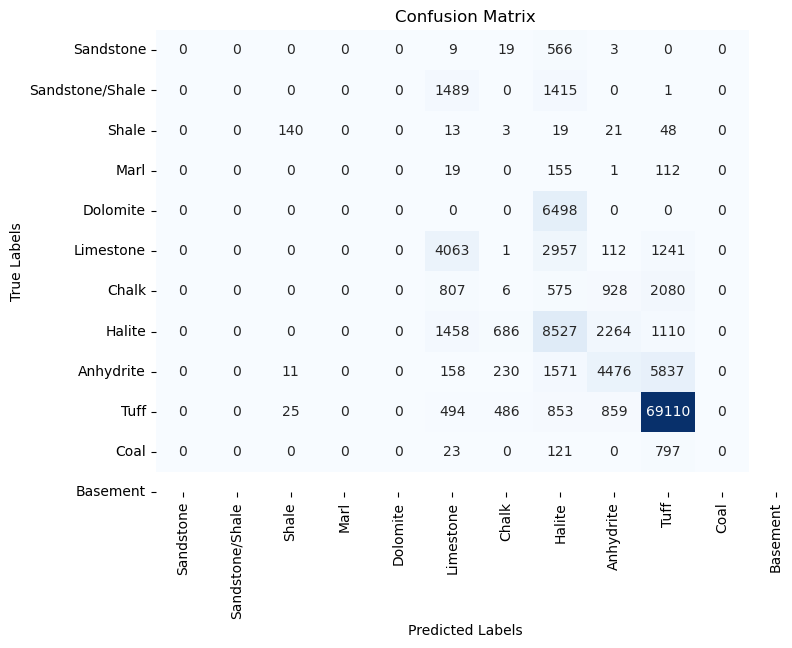

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create a confusion matrix
conf_matrix = confusion_matrix(true_labels, prediction_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=lithology_labels.values(), yticklabels=lithology_labels.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


# Without K-fold

In [10]:
from sklearn.model_selection import train_test_split

# Splitting the data into training and validation sets (80% training, 20% validation)
X_train, X_val, Y_train, Y_val = train_test_split(trainset, labels, test_size=0.2, stratify=labels, random_state=0)

#100 n-estimators and 10 max-depth
model = XGBClassifier(n_estimators=100, max_depth=10, booster='gbtree',
                      objective='multi:softprob', learning_rate=0.1, random_state=0,
                      subsample=0.9, colsample_bytree=0.9, tree_method='gpu_hist',
                      eval_metric='mlogloss', verbose=2020, reg_lambda=1500)

# Training the model
model.fit(X_train, Y_train, early_stopping_rounds=100, eval_set=[(X_val, Y_val)], verbose=100)

# Making predictions on the validation set
prediction = model.predict(X_val)
print(show_evaluation(prediction, Y_val))

# Making predictions on the test set
open_test = model.predict_proba(testset)
open_test = open_test.argmax(axis=1)

/home/dnlab/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[12:04:55] WARNING: ../src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:2.16583
[99]	validation_0-mlogloss:0.32331
Default score: -0.28050259928322147
Accuracy is: 0.893076978936622
F1 is: 0.8971550346849022
None


In [20]:
# Hidden test accuracy without K-Fold cross-validation
f1 = f1_score(true_labels, prediction_labels, average='weighted')
print(f"F1 score: {f1}")

F1 score: 0.6341959642573898
